# Exploration and Preprocessing

This notebook enables some simple visualization of the data contained in a given datasheet within the vgp database.

In [1]:
import os
import numpy as np
import pandas as pd
from pmagpy import ipmag, pmag
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
from scipy import optimize
import seaborn as sns

from vgptools.auxiliar import (get_files_in_directory, spherical2cartesian, cartesian2spherical, GCD_cartesian, 
                               print_pole_statistics, test_fishqq, reversal_test, invert_polarity, Plot_VgpsAndSites,
                               bayes_probability_heslop, bayes_support)

pd.set_option('display.max_columns', None)

We retrieve all the `.csv` files corresponding to diffenrent site studies. 

In [2]:
current_path = os.getcwd()
data_path_VGP = current_path + '/data/vgp_database'
files_names = get_files_in_directory(data_path_VGP)

xlsx_file_names = [os.path.splitext(os.path.basename(open(file,'r').name))[0] for file in files_names if file.endswith('.xlsx')] 
paths = [file for file in files_names if file.endswith('.xlsx')] 
df_files = pd.DataFrame({'path': paths,  'name_xlsx': xlsx_file_names})
df_files[['name_xlsx']].head()

name_xlsx
0        Valles_Caldera_volcanics
1        Mogollon-Datil_volcanics
2                Stanislaus_Group
3                 Dinan_Bay_lavas
4  Robinson_Antincline_intrusions

## Single site study

In order to understand what is going on in one single site, we can make different test statistics. 

In [5]:
file_idx = 20

#### Separate the *.xlsx file into two different DFs, `df_vgps` and `df_poles`. 
Note: the the number of lines to be skip is harcoded

In [4]:
print(split_datashet)

NameError: name 'split_datashet' is not defined

In [6]:
def split_datasheet (df_files, file_idx):
    """
    Reads in datasheets and splits them into pole and vgp collections to be filtered, collated and compiled.
    Input: standard vgp datasheet (as described in datasheet template)
    Output: separate dataframes comprised of the study-level poles and site-level vgps extracted from the datasheet
    """
    df = pd.read_excel(df_files['path'][file_idx]) #, skip_blank_lines=True
    df_poles = pd.read_excel(df_files['path'][file_idx], 
                             skiprows = df[df.iloc[:,0]=='Study level data'].index[0]+2,
                             nrows  = df[df.isnull().all(1)].index[1] -3)

    df_vgps = pd.read_excel(df_files['path'][file_idx], 
                            skiprows = df[df.iloc[:,0]=='Site level data'].index[0]+2)

    #cast columns
    df_vgps = df_vgps.astype({'in_study_pole': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "VGP_lat":float, "VGP_lon":float
                             })
    df_poles = df_poles.astype({'N': int,
                              "slat":float, "slon":float, "dec":float, "inc":float,
                              "Plat":float, "Plon":float})
    return (df_poles, df_vgps)

df_poles, df_vgps = split_datasheet(df_files, file_idx)

## We then proceed to populate the VGP DataFrame (`df_vgps`) following different criteria
 1. In a previous step, we have calculated the site coordinates of all studies in which these coordinates were not reported, but the Dec/Inc and Plat/Plon were. 
 2. When VGP coordinates are NOT reported in the original manuscript but the dec/inc and location of the sites was, we calculate them, and take them as face value.

In [7]:
# df_vgps['VGP_lon'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0] if (np.isnan(row.VGP_lon) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lon, axis =1) 
# df_vgps['VGP_lat'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1] if (np.isnan(row.VGP_lat) & (~np.isnan(row.dec) & ~np.isnan(row.slat))) else row.VGP_lat, axis =1) 

## Check polarity of VGPs against directions
 3. Some sites report the backward VGP (so that the VGPs are in the same hemisphere/closer to the principal component). We proceed to check polarity of VGPs against directions. To do that, we recalculate the vgps from the original Dec/Inc.

In [8]:
#First we calculate for the entire dataframe the vgps if there is dec/inc and slat/slon values
def recalc_vgps(df_vgps):
    df_vgps['VGP_lon_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[0], axis =1)
    df_vgps['VGP_lat_recalc'] = df_vgps.apply(lambda row: pmag.dia_vgp(row.dec, row.inc, 1, row.slat, row.slon)[1], axis =1)
    return df_vgps

df_vgps = recalc_vgps(df_vgps)

 4. Check distance (`df_vgps['GCD_vgps']`) between the reported VGPs and the recalculated from the directions.

In this step we fill the column `df_vgps['coherent_vgps']` with the following tags: 
- 'spurious' if inconsistent combination of site coordinates + dec/inc + vgp data (+- 4 degrees away from the reported or its backward)
- 'coherent' if correct
- 'inverted' if inverted

In [9]:
def check_coherence_vgps(df_vgps):

    df_vgps['GCD_vgps'] = df_vgps.apply(lambda row: GCD_cartesian(spherical2cartesian([np.radians(row.VGP_lat), np.radians(row.VGP_lon)]), spherical2cartesian([np.radians(row.VGP_lat_recalc), np.radians(row.VGP_lon_recalc)])), axis=1)

    # False if Spurious, True if correct, nan if inverted
    df_vgps['coherent_vgps'] = df_vgps.apply(lambda row: 'spurious' if (row.GCD_vgps > np.radians(4) and row.GCD_vgps < np.radians(176)) else ('coherent' if row.GCD_vgps < np.radians(4) else 'inverted' if row.GCD_vgps > np.radians(176) else np.nan ), axis =1) #True if it is ok, nan
    
    return df_vgps
df_vgps = check_coherence_vgps(df_vgps)

### Catch some exceptions:
 - Missing slat/slon and/or dec/in where no vgp is reported
 - Missing dec/inc and/or vgp where no site coordinates are reported; cannot calculate site locations.
 - Inconsistent combination of site coordinates + dec/inc + vgp
 - Recalculated VGP was inverted. 

In [10]:
def verbose(df_vgps):
    
    if not df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna())].empty:
        print (f" => Missing slat/slon from sites ('name'): {df_vgps[(df_vgps['slat'].isna() | df_vgps['slon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna())].empty:
        print (f" => Missing dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() | df_vgps['inc'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna())].empty:
        print (f" => Missing reported VGPs from sites ('name'): {df_vgps[(df_vgps['VGP_lat'].isna() | df_vgps['VGP_lon'].isna()) ].name.tolist()}")
        print (f"")

    if not df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].empty:    
        print (f" => Missing slat/slon and/or dec/inc from sites ('name'): {df_vgps[(df_vgps['dec'].isna() & df_vgps['slat'].isna())].name.tolist()} where no vgp is reported; cannot calculate vgp")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'spurious'].empty:
        print (f" => Inconsistent combination of site coordinates + dec/inc + vgp data from site(s) {df_vgps[df_vgps['coherent_vgps'] == 'spurious'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'inverted'].empty:
        print (f" => inverted vgp from sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'inverted'].name.tolist()}")
        print (f"")

    if not df_vgps[df_vgps['coherent_vgps'] == 'coherent'].empty:
        print (f" => Coherent dec/inc in sites ('name'): {df_vgps[df_vgps['coherent_vgps'] == 'coherent'].name.tolist()}")
        print (f"")
        
verbose(df_vgps)

 => Missing reported VGPs from sites ('name'): ['1C138*']

 => Coherent dec/inc in sites ('name'): ['1C614', '1C651', '1C671', '1C684', '1C701', '2C551', '2C801*', '2C804', '3V021', '3V028', '3V038', '3V048', '3V061', '3V077', '1C118', '2C809', '2C821', '2D005', '2D041*', '2D045', '2D051*', '2D056*', '2D066*', '2D072', '3D101', '3D115', '3D131', '3D138', '3V069', '3X209', '3X245', '3X901*', '3X906', '3X914', '3X921', '4D122', '1C601', '2C516*', '2C576', '2C582', '2C591', '2D001*', '3D107', '3V101', '3V121', '3V148', '3X020', '3X031', '3X038', '4D082', '4D090', '4D183', '4D191', '9E224', '3V001', '3V012*', '3V085', '3V093', '3V109', '3V167', '3X001', '3X013', '4D174', '5G102*', '5G113*', '5G122*', '5G133', '1C143*', '1C151', '1C160*', '2C508*', '2D010*', '2D018*', '2D025*', '2D031*', '2D036*', '3V129*', '3V138*', '3V156', '3V176', '3X216', '3X252*', '3X259', '4D098', '4D106', '4D114', '4D130', '4D140', '4D148', '4D155', '4D165', '4D218', '4D227']



### Now, for each reported pole from the selected manuscript we iterate through the constituent site-level data and: 
1) cast all vgps into a common polarity and re-compute the Fisher mean
2) plot the site locations, vgps, and the results of reversal and Fisher distribution tests

==>Analizing pole 1 (SW_USA_composite).


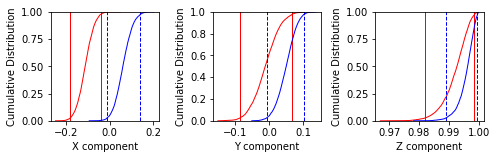

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Different means: positive support


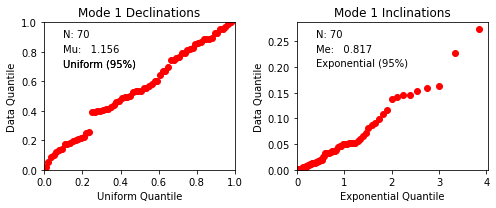

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        70       87.4     162.9     3.9
Recomputed paleopole             1.0        70       87.4     162.9     3.9
Recomputed pp from dir.          1.0        70       87.4     163.0     3.9



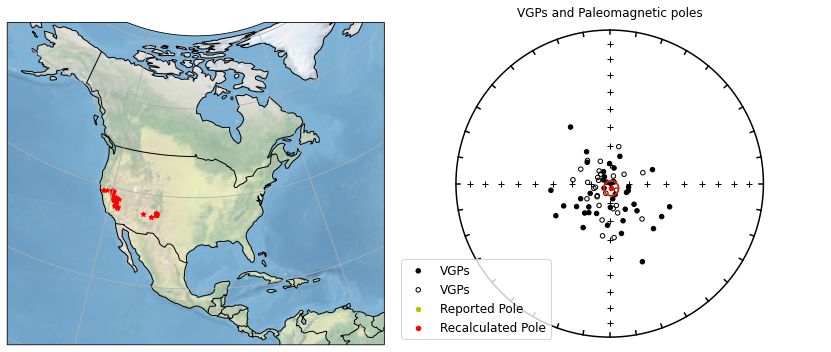

In [11]:
#Groupby iterates through DFs (i) 'grouped by' the column of interest 
misf1= []
misf2= []
studies= []
pps= []
for pole, df_pole in df_vgps.groupby('in_study_pole'):

    # value represent the index and i represent the DF grouped by the variable of interest  
    if pole != 0: #discards vgps discarded by authors
               
        print(f"==>Analizing pole {pole} ({df_files.name_xlsx[file_idx]}).")
        try:
          
            #split recalculated vgp population into different polarities by comparison against principal component axis             
            vgp_recalc_block = list(zip(df_pole['VGP_lon_recalc'].tolist(), df_pole['VGP_lat_recalc'].tolist()))            
            mode1, mode2 = pmag.separate_directions(di_block=vgp_recalc_block)
            
            #reversal test            
            reversal_test(mode1, mode2)    
            
            #Bayesian reversal Test
            P = bayes_probability_heslop(mode1, mode2)
            if P != 9999: print(f"Bayesian reversal test (Heslop & Roberts, 2018) indicates: {bayes_support(P)}")            
            
            #invert one polarity population, merge populations and test whether a distribution is Fisherian
            merged = invert_polarity(mode1, mode2)
            test_fishqq(merged)
                                                        
            # calculate the Fisher mean of reported VGPs to test reproducibility (we first fill the 'reported' if empty)
            df_pole['VGP_lat'] = np.where(df_pole['VGP_lat'].isna(), df_pole['VGP_lat_recalc'], df_pole['VGP_lat'])
            df_pole['VGP_lon'] = np.where(df_pole['VGP_lon'].isna(), df_pole['VGP_lon_recalc'], df_pole['VGP_lon'])
            
            df_pole['vgp_lat_NH'] = np.where(df_pole['VGP_lat'] < 0, -df_pole['VGP_lat'], df_pole['VGP_lat'])
            df_pole['vgp_lon_NH'] = np.where(df_pole['VGP_lat'] < 0,(df_pole['VGP_lon'] - 180.) % 360., df_pole['VGP_lon'])             
            
            vgp_mean_recomputed = ipmag.fisher_mean(di_block = merged)
            vgp_mean = ipmag.fisher_mean(dec = df_pole['vgp_lon_NH'].tolist(), inc = df_pole['vgp_lat_NH'].tolist())

            #Reported pole
            pp = df_poles[df_poles['pole'] == pole]

            print_pole_statistics(pp, vgp_mean, vgp_mean_recomputed)
                        
            # Plot sites and directions
            Plot_VgpsAndSites(df_pole, pp, vgp_mean, mode1, mode2)      

        except: #could be expanded!
            print(f" DEBUG POLE (index): {file_idx}, in_situ_pole: {pole}") 


# Iterate through all the files to catch exceptions:


========================= NEW POLE : Valles_Caldera_volcanics (0) =======================
 => Coherent dec/inc in sites ('name'): ['S47', 'S46', 'S45', 'S44', 'S43', 'S42', 'S41', 'S40', 'S39', 'S38', 'S37', 'S35', 'S34', "Anorthoclase' unit", 5.0, 4.0, 3.0, 2.0, 1.0, 'S31: Upper member mean', 6.0, 5.0, 4.0, 3.0, 2.0, 1.0, 'S30: Lower member mean', 'S29']

==>Analizing pole 1 (Valles_Caldera_volcanics).


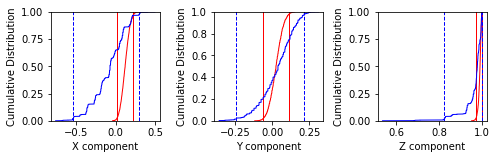

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


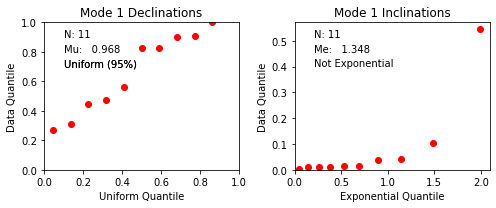

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        10       nan       nan      nan
Recomputed paleopole             1.0        11       87.1      38.6    13.4
Recomputed pp from dir.          1.0        11       87.1      38.5    13.4



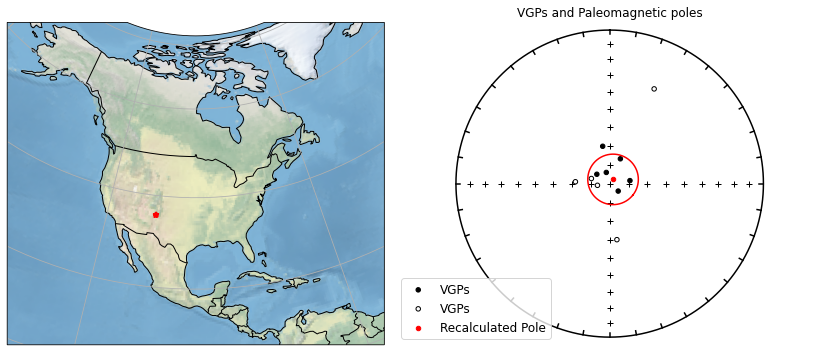


========================= NEW POLE : Mogollon-Datil_volcanics (1) =======================
 => Missing reported VGPs from sites ('name'): ['74#', 6.0, '33#', '19#', '44#', '48#', '73#', '78#', 24.0, 25.0, 55.0, 137.0, 183.0, 185.0, 186.0, 199.0, 215.0, 216.0, 217.0, 218.0, 219.0, 338.0, 348.0, 364.0, 424.0, 176.0, 184.0, 115.0, 471.0, 473.0, 'Slash Ranch mean', 4.0, 7.0, 36.0, 105.0, 138.0, 187.0, 188.0, 197.0, 250.0, 251.0, 252.0, 258.0, 380.0, 515.0, 8.0, 242.0, 13.0, 166.0, 53.0, 58.0, 60.0, 61.0, 63.0, 80.0, 81.0, 82.0, 172.0, 57.0, 62.0, 47.0, 59.0, 19.0, 20.0, 23.0, 26.0, 27.0, 28.0, 29.0, 173.0, 367.0, '368', 369.0, 370.0, 510.0, 9.0, 21.0, 22.0, 46.0, 54.0, 56.0, 104.0, 161.0, 165.0, 198.0, 10.0, 11.0, 12.0, 30.0, 40.0, 41.0, 45.0, 196.0, 50.0, 64.0, 162.0, 'Lemitar mean', 167.0, 168.0, 195.0, 545.0, 543.0, 140.0, 141.0, 142.0, 158.0, 160.0, 159.0, 78.0, 94.0, 95.0, 101.0, 112.0, 114.0, 139.0, 144.0, 148.0, 155.0, 228.0, 230.0, 266.0, 298.0, 318.0, 332.0, 428.0, 429.0, 430.0, 4

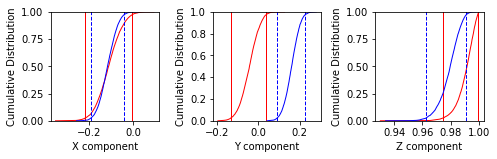

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Different means: positive support


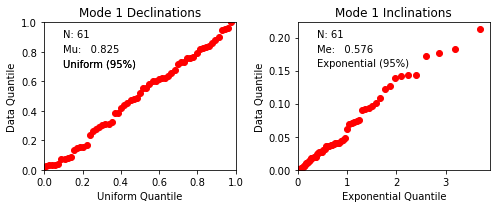

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        61       81.9     143.6     4.5
Recomputed paleopole             1.0        61       82.0     143.4     4.5
Recomputed pp from dir.          1.0        61       81.9     143.3     4.5



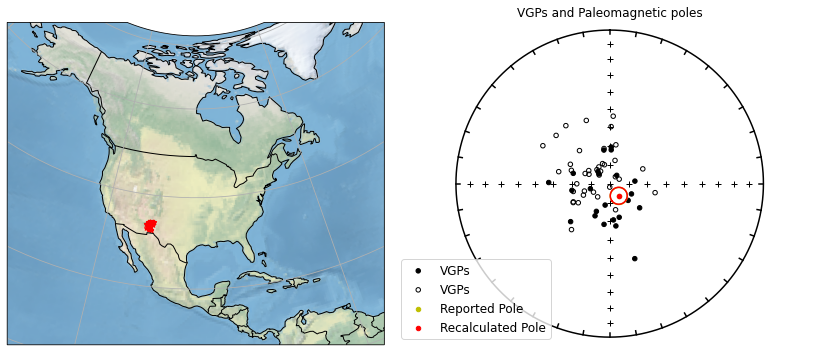

==>Analizing pole 2 (Mogollon-Datil_volcanics).


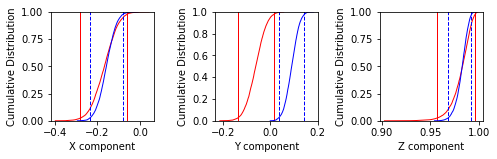

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


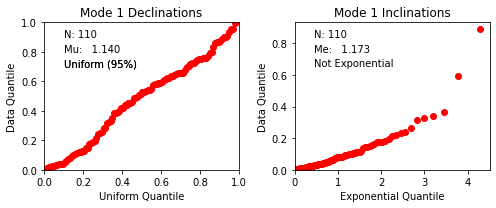

                                 Pole       N        Plat      Plon     A95
Reported paleopole               2.0       106       78.8     175.0     3.8
Recomputed paleopole             2.0       110       81.4     163.1     4.2
Recomputed pp from dir.          2.0       110       80.4     166.9     4.2



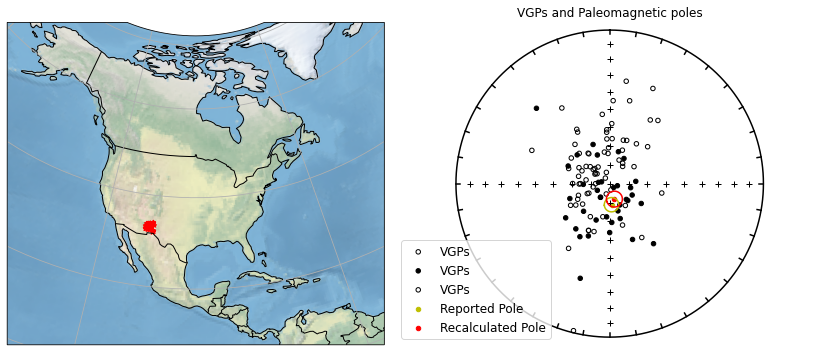


========================= NEW POLE : Stanislaus_Group (2) =======================
 => Missing reported VGPs from sites ('name'): ['Upper Member mean', 'By-Day Member mean', 'Tollhouse Flat Member mean', 'Table Mountain Latite (west) average']

 => Coherent dec/inc in sites ('name'): ['BP5', 'WD4', 'WD7', 'BP7', '3V156', 'LW96', 'LW93', 'LW23', 'LW92', 'LW95', 'BP3', 'LW25', 'LW90', 'LW91', 'LW94', 'LW88', 'LW86', '3V138', '3V129', 'JR', 'WD10', 'MK13', 'LW97', 'DM11', 'DM9', 'DM6', 'DM3', 'DM1', 'MK1', 'PW26', 'RH3', 'WD2', 'LW98', 'RR', 'MC', 'LG']

==>Analizing pole 1 (Stanislaus_Group).


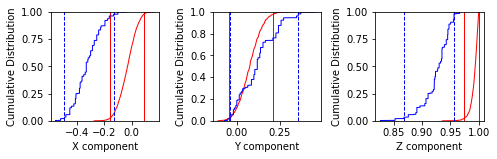

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


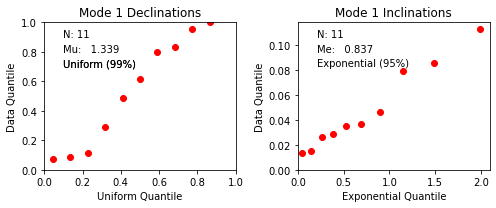

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        11       nan       nan      nan
Recomputed paleopole             1.0        11       80.2     146.4    10.3
Recomputed pp from dir.          1.0        11       80.2     146.4    10.3



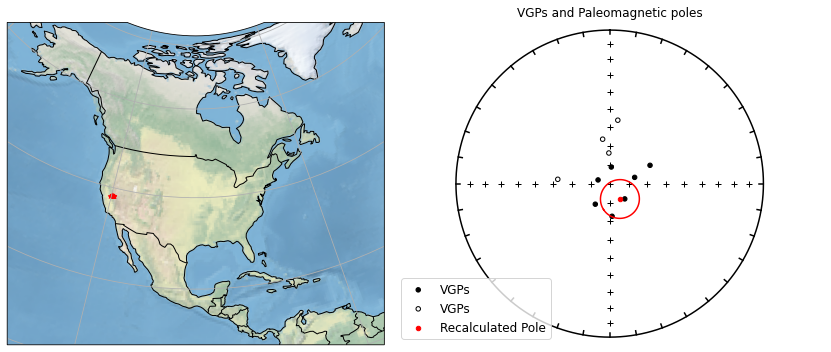


========================= NEW POLE : Dinan_Bay_lavas (3) =======================
 => Missing reported VGPs from sites ('name'): [46.0, 47.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0]

==>Analizing pole 1 (Dinan_Bay_lavas).


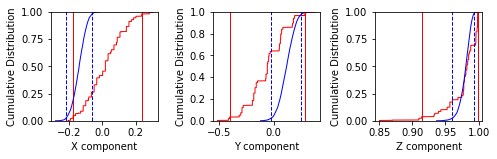

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


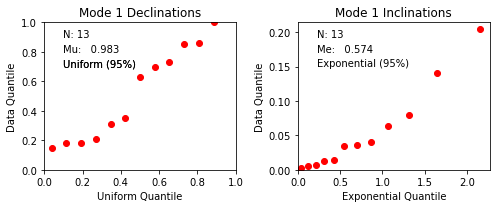

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        13       83.3     137.8     9.8
Recomputed paleopole             1.0        13       83.3     144.3     9.8
Recomputed pp from dir.          1.0        13       83.3     144.3     9.8



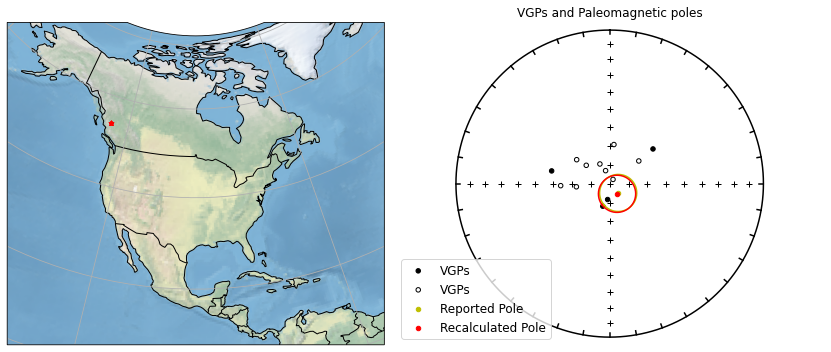


========================= NEW POLE : Robinson_Antincline_intrusions (4) =======================
 => Missing reported VGPs from sites ('name'): [1.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0]

==>Analizing pole 1 (Robinson_Antincline_intrusions).


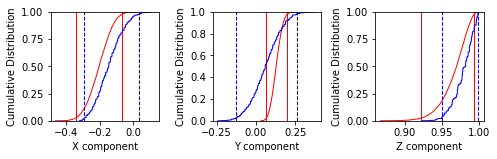

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


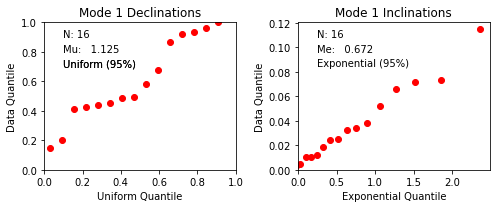

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        16       nan       nan      nan
Recomputed paleopole             1.0        16       77.5     149.8     7.5
Recomputed pp from dir.          1.0        16       77.5     149.8     7.5



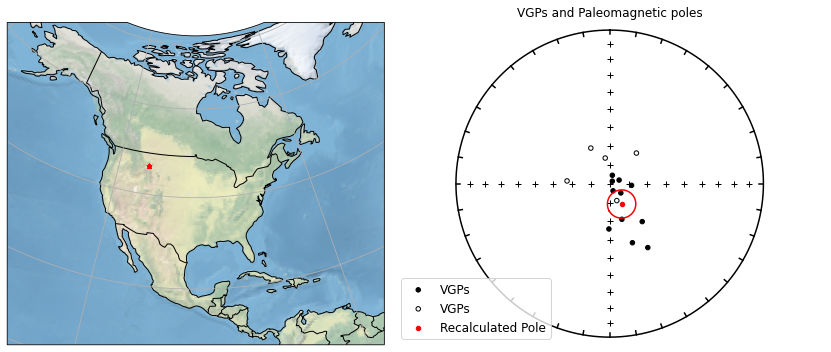


========================= NEW POLE : Mariscal_Mtn_intrusions (5) =======================
 => Coherent dec/inc in sites ('name'): ['mm8', 'mm9', 'mm10', 'mm12', 'mm13', 'mm18', 'mm19*', 'mm20', 'mm21', 'mm22*', 'mm23', 'mm24', 'mm25', 'mm26', 'mm30', 'mm31', 'mm37', 'mm39', 'mm42a', 'mm42b*', 'mm44']

==>Analizing pole 1 (Mariscal_Mtn_intrusions).
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
 - Only one polarity; cannot conduct Bayesian Reversal Test


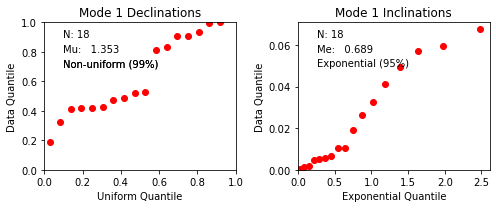

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        18       80.0     185.3     5.4
Recomputed paleopole             1.0        18       80.0     185.2     5.4
Recomputed pp from dir.          1.0        18       80.0     185.3     5.4



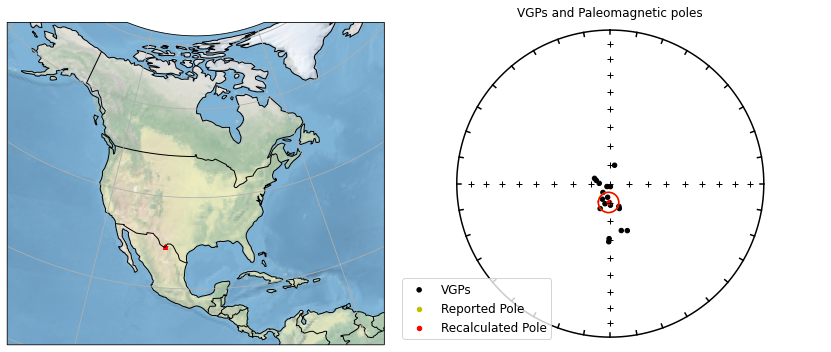


========================= NEW POLE : Eastern_Alkaline_Province (6) =======================
 => Missing reported VGPs from sites ('name'): ['VE17']

 => Coherent dec/inc in sites ('name'): ['VE18', 'VE19', 'VE10', 'VE13', 'VE12', 'VE09', 'VE11', 'VE14', 'VE16', 'VE05', 'VE03', 'VE02', 'VE04', 'VE07', 'VE01', 'VE06', 'VE15', 'VE08']

==>Analizing pole 1 (Eastern_Alkaline_Province).


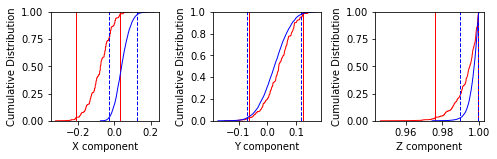

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


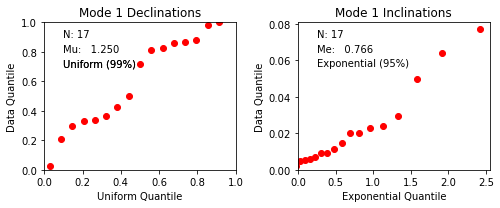

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        17       nan       nan      nan
Recomputed paleopole             1.0        17       88.3      93.4     5.5
Recomputed pp from dir.          1.0        17       88.3      87.7     5.5



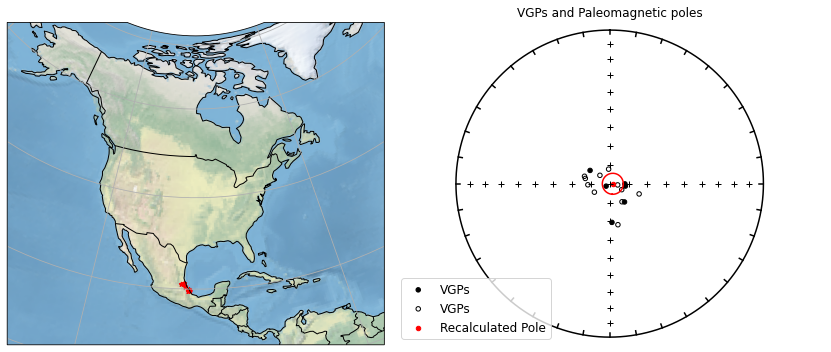


========================= NEW POLE : Bitterroot_Dome_intrusions (7) =======================
 => Coherent dec/inc in sites ('name'): ['B01', 'B02', 'B03', 'B05', 'B06', 'B09', 'B09a', 'B09b', 'B10', 'B11', 'B11a', 'B11b', 'B12', 'B12a', 'B12b', 'B15', 'B15a', 'B15b', 'B18', 'S03', 'S04', 'S07', 'S10', 'S12', 'S13', 'S16', 'S17']

==>Analizing pole 1 (Bitterroot_Dome_intrusions).


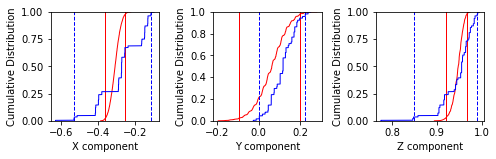

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Common mean: positive support


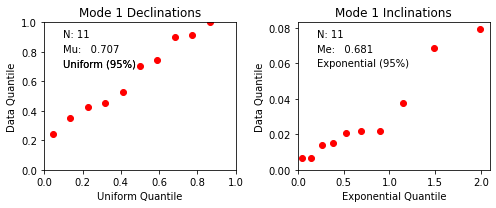

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        11       nan       nan      nan
Recomputed paleopole             1.0        11       72.3     165.0     7.9
Recomputed pp from dir.          1.0        11       72.2     164.4     7.9



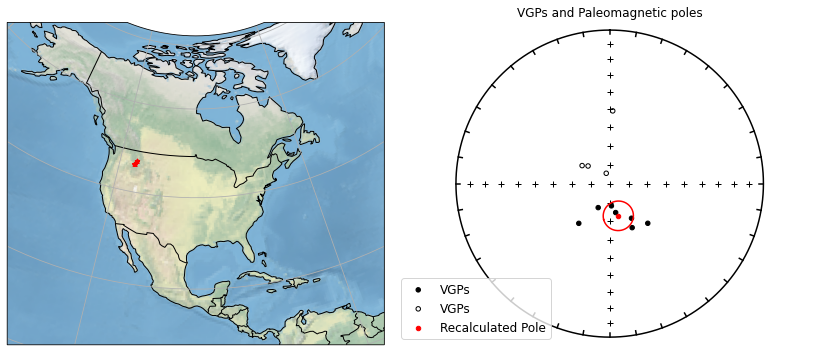

==>Analizing pole 2 (Bitterroot_Dome_intrusions).


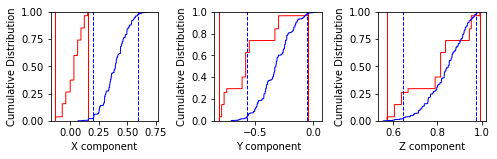

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support
 - Not enough sites to conduct quantile-quantile test
                                 Pole       N        Plat      Plon     A95
Reported paleopole               2.0        8        nan       nan      nan
Recomputed paleopole             2.0        8        59.3     301.6    20.8
Recomputed pp from dir.          2.0        8        59.2     302.1    20.8



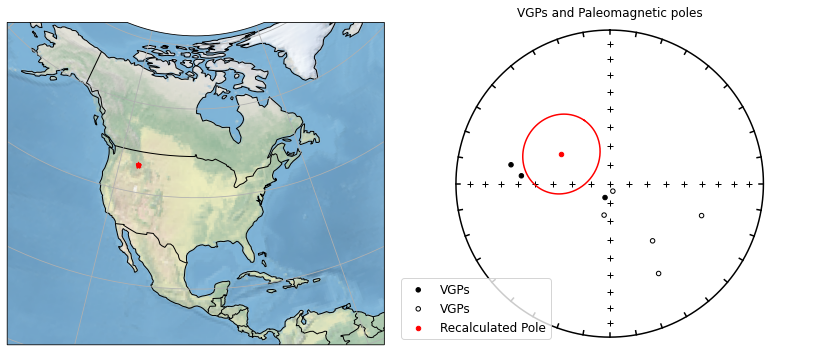


========================= NEW POLE : East_Fork_Basin_sediments (8) =======================

========================= NEW POLE : Mistastin_Lake_impact (9) =======================
 => Missing reported VGPs from sites ('name'): [1.0, 2.0, 3.0, '4_adj', '5_adj', 6.0, '7_adj', 8.0, 9.0, 10.0, 12.0, 1.0, 2.0, 3.0, 4.0, 5.0, 11.0, 10.0, 9.0, 6.0, '6-ani', 7.0, '7-ani', 13.0, 14.0, 15.0, 17.0]

==>Analizing pole 1 (Mistastin_Lake_impact).
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
 - Only one polarity; cannot conduct Bayesian Reversal Test
 - Not enough sites to conduct quantile-quantile test
                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        10       85.5     117.7     nan
Recomputed paleopole             1.0        10       85.5     121.0     4.4
Recomputed pp from dir.          1.0        10      -85.5     301.0     4.4



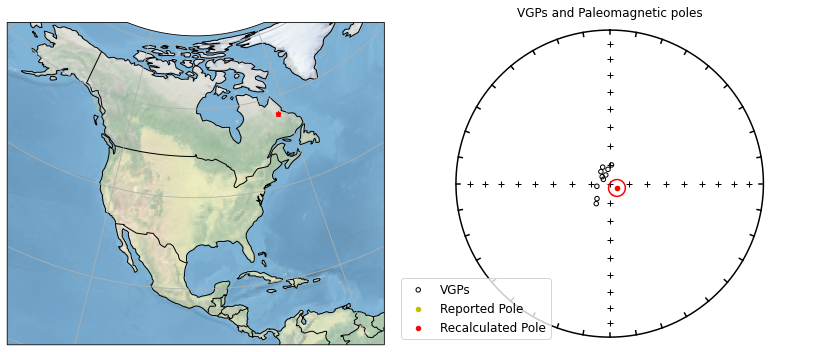

==>Analizing pole 2 (Mistastin_Lake_impact).
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
 - Only one polarity; cannot conduct Bayesian Reversal Test


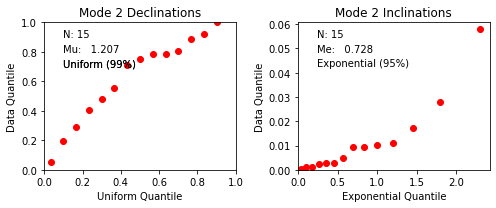

                                 Pole       N        Plat      Plon     A95
Reported paleopole               2.0        15       nan       nan      nan
Recomputed paleopole             2.0        15       83.7      99.9     4.1
Recomputed pp from dir.          2.0        15      -83.7     279.9     4.1



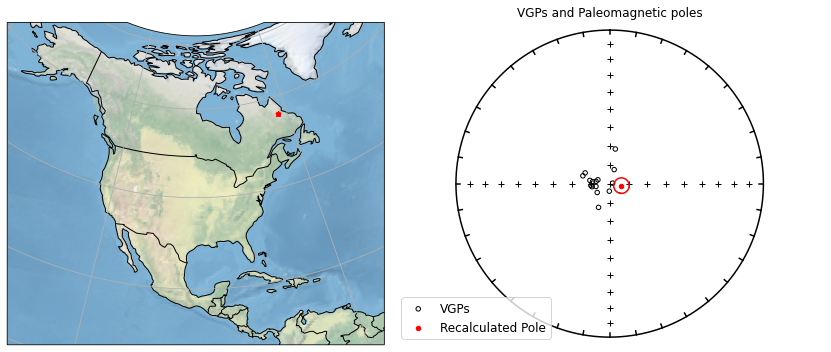


========================= NEW POLE : Absaroka_volcanics (10) =======================
 => Missing reported VGPs from sites ('name'): [10.0, 'Lower Flow mean', 'Middle Flow mean', 'Upper Flow mean', 620.0, 622.0, 617.0, '617+624+625 mean', 'I8']

 => inverted vgp from sites ('name'): ['7*', 8.0, '35*', '4b', '4a', 4.0, '5b', '5a', 5.0, 44.0, '43*', '3b', '3a', 3.0, '2b', '2a', '2*', '16b', '16a', 16.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 55.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 389.0, 390.0, '389+390 mean', 394.0, 396.0, 624.0, 625.0, 'I1', 'I2', 'I3', 'I4', 'I6', 'I7', 'Independence stock mean', 'I5']

 => Coherent dec/inc in sites ('name'): [6.0, '33*', '34*', '36*', '37*', '38*', 39.0, 40.0, '41*', 51.0, '50*', '49*', 48.0, '47*', 31.0, 32.0, 14.0, '13*', 

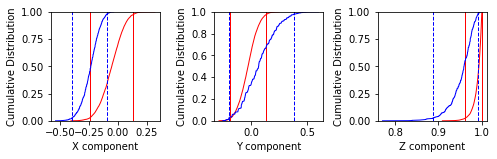

Bayesian reversal test (Heslop & Roberts, 2018) indicates: Ambiguous: weak support


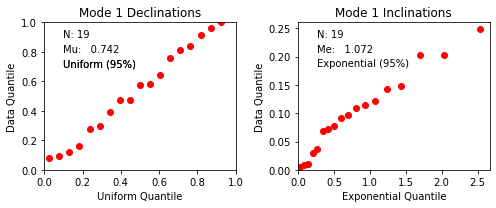

                                 Pole       N        Plat      Plon     A95
Reported paleopole               1.0        19       83.5     177.4    10.1
Recomputed paleopole             1.0        19       83.4     178.6    11.1
Recomputed pp from dir.          1.0        19       83.4     178.6    11.1



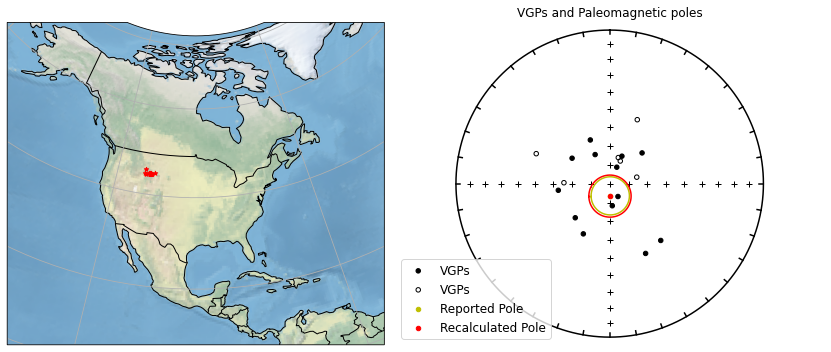

==>Analizing pole 2 (Absaroka_volcanics).
 
 - Only one polarity; cannot conduct Bootstrapped reversal test
 - Only one polarity; cannot conduct Bayesian Reversal Test
 - Not enough sites to conduct quantile-quantile test
                                 Pole       N        Plat      Plon     A95
Reported paleopole               2.0        3        nan       nan      nan
Recomputed paleopole             2.0        3        65.6      94.6    58.4
Recomputed pp from dir.          2.0        3       -65.6     274.6    58.4



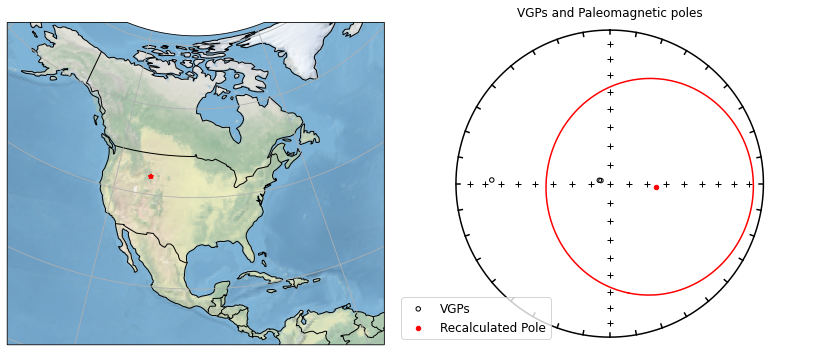

==>Analizing pole 3 (Absaroka_volcanics).


In [ ]:
studies, pps, misf, froms = [], [], [], []
for file_idx in range(len(df_files) -1):
    
    print(f'')
    print(f'========================= NEW POLE : {df_files.name_xlsx[file_idx]} ({file_idx}) =======================')
    
    df_poles, df_vgps = split_datasheet(df_files, file_idx)
    
    if df_vgps.empty: continue
        
    df_vgps = recalc_vgps(df_vgps)
    
    df_vgps = check_coherence_vgps(df_vgps)
   
    verbose(df_vgps)
    
    #Groupby iterates through DFs (i) 'grouped by' the column of interest 
    
    

    
    for pole, df_pole in df_vgps.groupby('in_study_pole'):

        # value represent the index and i represent the DF grouped by the variable of interest  
        if pole != 0: #discards vgps discarded by authors

            print(f"==>Analizing pole {pole} ({df_files.name_xlsx[file_idx]}).")
            try:

                #split recalculated vgp population into different polarities by comparison against principal component axis             
                vgp_recalc_block = list(zip(df_pole['VGP_lon_recalc'].tolist(), df_pole['VGP_lat_recalc'].tolist()))            
                mode1, mode2 = pmag.separate_directions(di_block=vgp_recalc_block)

                #reversal test            
                reversal_test(mode1, mode2)    

                #Bayesian reversal Test
                P = bayes_probability_heslop(mode1, mode2)
                if P != 9999: print(f"Bayesian reversal test (Heslop & Roberts, 2018) indicates: {bayes_support(P)}")            

                #invert one polarity population, merge populations and test whether a distribution is Fisherian
                merged = invert_polarity(mode1, mode2)
                test_fishqq(merged)

                # calculate the Fisher mean of reported VGPs to test reproducibility (we first fill the 'reported' if empty)
                df_pole['VGP_lat'] = np.where(df_pole['VGP_lat'].isna(), df_pole['VGP_lat_recalc'], df_pole['VGP_lat'])
                df_pole['VGP_lon'] = np.where(df_pole['VGP_lon'].isna(), df_pole['VGP_lon_recalc'], df_pole['VGP_lon'])

                df_pole['vgp_lat_NH'] = np.where(df_pole['VGP_lat'] < 0, -df_pole['VGP_lat'], df_pole['VGP_lat'])
                df_pole['vgp_lon_NH'] = np.where(df_pole['VGP_lat'] < 0,(df_pole['VGP_lon'] - 180.) % 360., df_pole['VGP_lon'])             

                vgp_mean_recomputed = ipmag.fisher_mean(di_block = merged)
                vgp_mean = ipmag.fisher_mean(dec = df_pole['vgp_lon_NH'].tolist(), inc = df_pole['vgp_lat_NH'].tolist())

                #Reported pole
                pp = df_poles[df_poles['pole'] == pole]

                print_pole_statistics(pp, vgp_mean, vgp_mean_recomputed)

                #di_block = ipmag.make_di_block(df_pole['VGP_lon'].tolist(),df_pole['VGP_lat'].tolist())

                # Plot sites and directions
                Plot_VgpsAndSites(df_pole, pp, vgp_mean, mode1, mode2) 
                
                
                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)
                misf.append(pmag.angle([vgp_mean['dec'], vgp_mean['inc']], [pp.iloc[0]['Plon'], pp.iloc[0]['Plat']])[0])
                froms.append('reported')
                
                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)                
                misf.append(pmag.angle([vgp_mean_recomputed['dec'], vgp_mean_recomputed['inc']], [pp.iloc[0]['Plon'], pp.iloc[0]['Plat']])[0])
                froms.append('recalculated')
                
            except: #could be expanded!
                print(f" DEBUG POLE (index): {file_idx}, in_situ_pole: {pole}") 


In [47]:
studies, pps, misf, froms = [], [], [], []
for file_idx in range(len(df_files) -1):
    
    print(f'')
    print(f'========================= NEW POLE : {df_files.name_xlsx[file_idx]} ({file_idx}) =======================')
    
    df_poles, df_vgps = split_datasheet(df_files, file_idx)
    
    if df_vgps.empty: continue
        
    df_vgps = recalc_vgps(df_vgps)
    
    df_vgps = check_coherence_vgps(df_vgps)
   
    #verbose(df_vgps)
    
    #Groupby iterates through DFs (i) 'grouped by' the column of interest 
    
    

    
    for pole, df_pole in df_vgps.groupby('in_study_pole'):

        # value represent the index and i represent the DF grouped by the variable of interest  
        if pole != 0: #discards vgps discarded by authors

            print(f"==>Analizing pole {pole} ({df_files.name_xlsx[file_idx]}).")
          
            try:
                #split recalculated vgp population into different polarities by comparison against principal component axis             
                vgp_recalc_block = list(zip(df_pole['VGP_lon_recalc'].tolist(), df_pole['VGP_lat_recalc'].tolist()))            
                mode1, mode2 = pmag.separate_directions(di_block=vgp_recalc_block)

                #reversal test            
                # reversal_test(mode1, mode2)    

                #Bayesian reversal Test
                # P = bayes_probability_heslop(mode1, mode2)
                # if P != 9999: print(f"Bayesian reversal test (Heslop & Roberts, 2018) indicates: {bayes_support(P)}")            

                #invert one polarity population, merge populations and test whether a distribution is Fisherian
                merged = invert_polarity(mode1, mode2)
                # test_fishqq(merged)

                # calculate the Fisher mean of reported VGPs to test reproducibility (we first fill the 'reported' if empty)
                df_pole['VGP_lat'] = np.where(df_pole['VGP_lat'].isna(), df_pole['VGP_lat_recalc'], df_pole['VGP_lat'])
                df_pole['VGP_lon'] = np.where(df_pole['VGP_lon'].isna(), df_pole['VGP_lon_recalc'], df_pole['VGP_lon'])

                df_pole['vgp_lat_NH'] = np.where(df_pole['VGP_lat'] < 0, -df_pole['VGP_lat'], df_pole['VGP_lat'])
                df_pole['vgp_lon_NH'] = np.where(df_pole['VGP_lat'] < 0,(df_pole['VGP_lon'] - 180.) % 360., df_pole['VGP_lon'])             

                vgp_mean_recomputed = ipmag.fisher_mean(di_block = merged)
                vgp_mean = ipmag.fisher_mean(dec = df_pole['vgp_lon_NH'].tolist(), inc = df_pole['vgp_lat_NH'].tolist())

                #Reported pole
                pp = df_poles[df_poles['pole'] == pole]

                #print_pole_statistics(pp, vgp_mean, vgp_mean_recomputed)

                #di_block = ipmag.make_di_block(df_pole['VGP_lon'].tolist(),df_pole['VGP_lat'].tolist())

                # Plot sites and directions
                # Plot_VgpsAndSites(df_pole, pp, vgp_mean, mode1, mode2) 

                # if not (len(vgp_mean_recomputed)!=0 & len(vgp_mean)!=0): 

                
                misf.append(pmag.angle([vgp_mean['dec'], vgp_mean['inc']], [pp.iloc[0]['Plon'], pp.iloc[0]['Plat']])[0])
                froms.append('reported')
                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)
                
                misf.append(pmag.angle([vgp_mean_recomputed['dec'], vgp_mean_recomputed['inc']], [pp.iloc[0]['Plon'], pp.iloc[0]['Plat']])[0])
                studies.append(df_files.name_xlsx[file_idx])
                pps.append(pole)                                
                froms.append('recalculated')
                    
            except: #could be expanded!
                print(f" DEBUG POLE (index): {file_idx}, in_situ_pole: {pole}") 
            


========================= NEW POLE : Absaroka_volcanics (0) =======================
==>Analizing pole 1 (Absaroka_volcanics).
==>Analizing pole 2 (Absaroka_volcanics).
==>Analizing pole 3 (Absaroka_volcanics).

========================= NEW POLE : Beaver_River_intrusions (1) =======================
==>Analizing pole 1 (Beaver_River_intrusions).

========================= NEW POLE : Bighorn_Basin_sediments (2) =======================
==>Analizing pole 1 (Bighorn_Basin_sediments).

========================= NEW POLE : Bishop_tuff (3) =======================
==>Analizing pole 1 (Bishop_tuff).
 DEBUG POLE (index): 3, in_situ_pole: 1

========================= NEW POLE : Bitterroot_Dome_intrusions (4) =======================
==>Analizing pole 1 (Bitterroot_Dome_intrusions).
==>Analizing pole 2 (Bitterroot_Dome_intrusions).

========================= NEW POLE : Central_Mexico_Plio-Pleistocene (5) =======================
==>Analizing pole 1 (Central_Mexico_Plio-Pleistocene).

===============

In [80]:

dictionary= {'Study': studies, 'in_study_pole': pps, 'Misfit': misf, 'From' : froms}
df_misfits = pd.DataFrame(dictionary)

df_misfits = df_misfits[~df_misfits['Misfit'].isna()]

df_misfits['Misfit'] = np.where(df_misfits['Misfit'] > 90, 180 - df_misfits['Misfit'], df_misfits['Misfit'])
df_misfits

Study  in_study_pole    Misfit          From
0                    Absaroka_volcanics              1  0.183503      reported
1                    Absaroka_volcanics              1  0.181705  recalculated
4                    Absaroka_volcanics              3  0.132521      reported
5                    Absaroka_volcanics              3  0.110828  recalculated
6               Beaver_River_intrusions              1  0.366473      reported
7               Beaver_River_intrusions              1  0.366473  recalculated
14      Central_Mexico_Plio-Pleistocene              1  0.344733      reported
15      Central_Mexico_Plio-Pleistocene              1  0.323528  recalculated
20                      Dinan_Bay_lavas              1  0.753719      reported
21                      Dinan_Bay_lavas              1  0.753719  recalculated
24                         Eastern_TMVB              1  1.323173      reported
25                         Eastern_TMVB              1  1.323173  recalculated
26                         Eastern_TMVB              2  1.389618      reported
27                         Eastern_TMVB              2  1.389618  recalculated
28                         Eastern_TMVB              3  0.809443      reported
29                         Eastern_TMVB              3  0.809443  recalculated
34              Mariscal_Mtn_intrusions              1  0.025776      reported
35              Mariscal_Mtn_intrusions              1  0.031500  recalculated
36  Michoacan_Guanajuato_volcanic_field              1  1.338717      reported
37  Michoacan_Guanajuato_volcanic_field              1  1.338717  recalculated
38                Mistastin_Lake_impact              1  0.259412      reported
39                Mistastin_Lake_impact              1  0.259412  recalculated
42             Mogollon-Datil_volcanics              1  0.092155      reported
43             Mogollon-Datil_volcanics              1  0.059457  recalculated
44             Mogollon-Datil_volcanics              2  2.101877      reported
45             Mogollon-Datil_volcanics              2  2.232144  recalculated
48                  Monterey_intrusions              2  2.129359      reported
49                  Monterey_intrusions              2  2.129359  recalculated
50                 N_Montana_intrusions              1  0.416402      reported
51                 N_Montana_intrusions              1  1.169622  recalculated
52                  Ramsay_Island_lavas              1  5.198304      reported
53                  Ramsay_Island_lavas              1  5.198304  recalculated
54          Rattlesnake_Hills_volcanics              1  0.027504      reported
55          Rattlesnake_Hills_volcanics              1  0.027504  recalculated
58             San_Luis_Hills_volcanics              1  1.225500      reported
59             San_Luis_Hills_volcanics              1  1.225345  recalculated
60                 Sierra_de_Las_Cruces              1  1.134276      reported
61                 Sierra_de_Las_Cruces              1  1.134276  recalculated
62                    Snake_River_Plain              1  0.025825      reported
63                    Snake_River_Plain              1  0.025825  recalculated
64                     Sonoma_volcanics              1  0.131832      reported
65                     Sonoma_volcanics              1  0.137908  recalculated
68                     SW_USA_composite              1  0.344783      reported
69                     SW_USA_composite              1  0.335172  recalculated
70               Tequila_volcanic_field              1  0.034935      reported
71               Tequila_volcanic_field              1  0.379493  recalculated

[Text(0.5, 1.0, 'Distance from the reported Paleopole and the reported VGPs')]

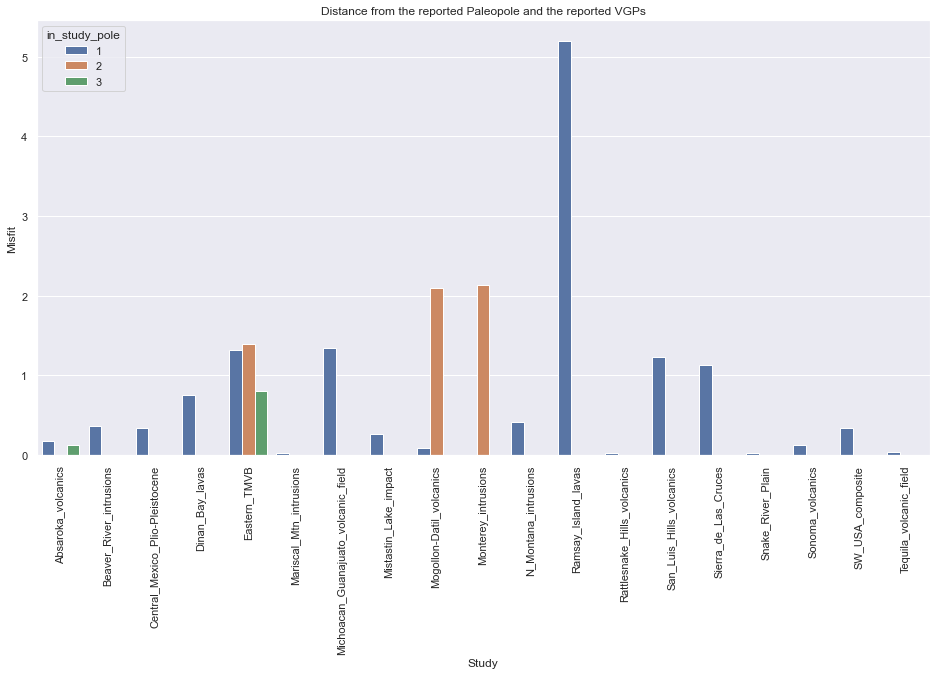

In [79]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Study", y= "Misfit", hue="in_study_pole", data=df_misfits[df_misfits['From'] == 'reported'])
ax.tick_params(axis='x', rotation=90)
ax.set(title = "Distance from the reported Paleopole and the reported VGPs")
#ax.xaxis.get_label().set_fontsize(20)

[Text(0.5, 1.0, 'Distance from the reported Paleopole and the recalculated VGPs')]

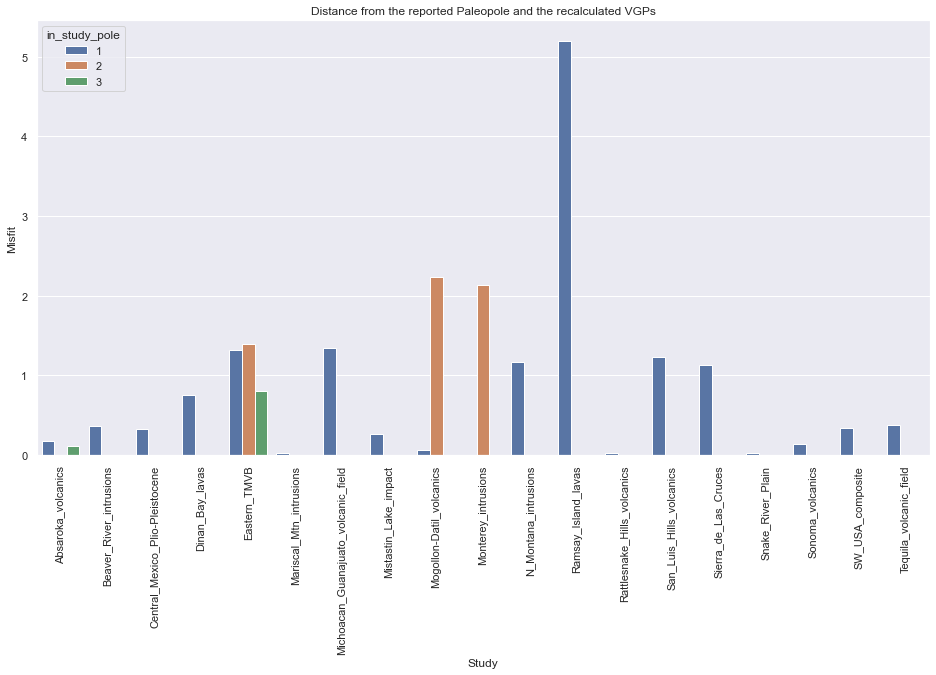

In [82]:
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(16,8)})
ax = sns.barplot(x="Study", y= "Misfit", hue="in_study_pole", data=df_misfits[df_misfits['From'] == 'recalculated'])
ax.tick_params(axis='x', rotation=90)
ax.set(title = "Distance from the reported Paleopole and the recalculated VGPs")
#ax.xaxis.get_label().set_fontsize(20)